### Importing necessary libraries

In [1]:
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from tensorflow import keras
import numpy as np
import random
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint 

### Loading CIFAR-10 Data

In [2]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [4]:
# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualising the first few Images

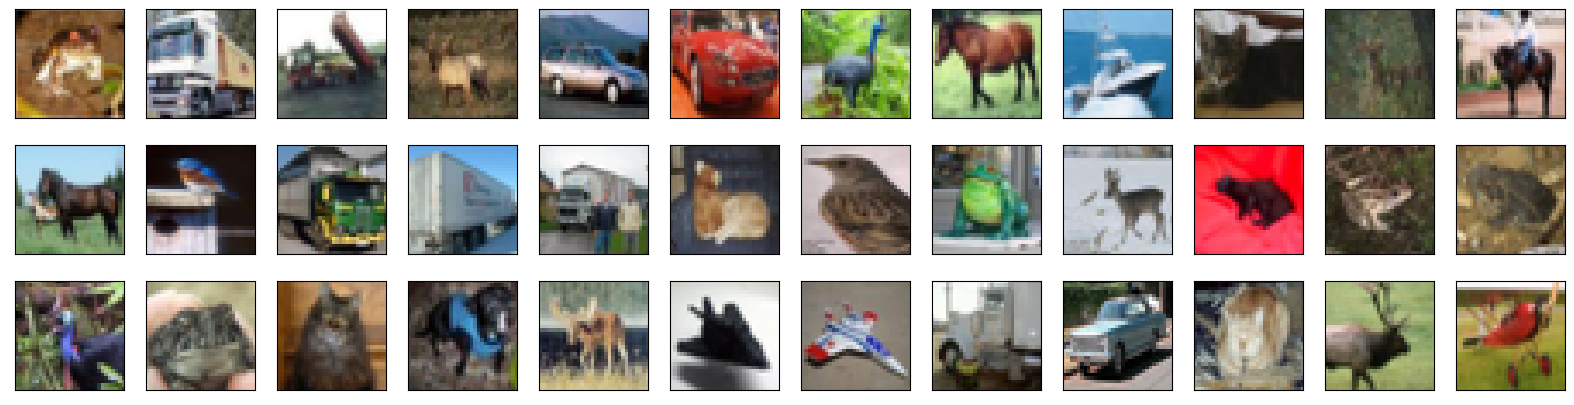

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

**3. Rescale the Images by Dividing Every Pixel in Every Image by 255**

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Figure below shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).

** Pointer: ** When using Gradient Descent, you should ensure that all features have a similar scale to speed up training or else it will take much longer to converge.

In [6]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [7]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    # size = len(data)//num_clients
    size = [10000,7000,4000,13000,16000]
#     size = [500,500,500,500,500]
    # shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    shards = []
    num1 = 0
    for i in range(len(size)):
        num2 = size[i]
        shards.append(data[num1:num1 + num2])
        num1 = num1+num2
    print(type(shards))

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

In [8]:
clients = create_clients(x_train, y_train, num_clients=5, initial='client')

<class 'list'>


In [9]:
len(clients['client_1']), len(clients['client_2']),len(clients['client_3']), len(clients['client_4']), len(clients['client_5'])

(10000, 7000, 4000, 13000, 16000)

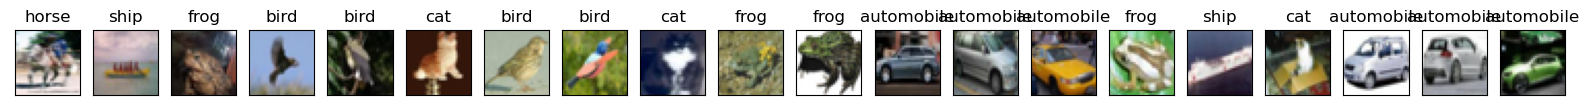

In [10]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    ax = fig.add_subplot(1, 20, i+1, xticks=[], yticks=[])
    ax.imshow(clients['client_1'][i][0], cmap='gray')
    ax.set_title(str(cifar10_labels[np.argmax(clients['client_1'][i][1])]))

In [11]:
os.getcwd()

'C:\\Users\\Amit Kumar\\Desktop\\Sally Salem'

In [12]:
current_directory = os.getcwd()

for client_name in clients.keys():
    final_directory = os.path.join(current_directory, client_name)
    if not os.path.exists(final_directory):
        os.makedirs(final_directory)
    os.chdir(final_directory)
    
    for j in range(len(clients[client_name])):
        img = clients[client_name][j][0]
        plt.imsave(client_name + "_" + str(j) + '.jpg',img)

In [13]:
x_train1 = x_train[0:10000,]
y_train1 = y_train[0:10000,]

x_train2 = x_train[10000:17000,]
y_train2 = y_train[10000:17000,]

x_train3 = x_train[17000:21000,]
y_train3 = y_train[17000:21000,]

x_train4 = x_train[21000:34000,]
y_train4 = y_train[21000:34000,]

x_train5 = x_train[34000:50000,]
y_train5 = y_train[34000:50000,]

In [14]:
class CNN:
    
    def build(self, classes):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
        model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(classes, activation='softmax'))
        
        return model


In [15]:
classes = 10
global_weights = []

X_train = [x_train1,x_train2,x_train3,x_train4,x_train5]
Y_train = [y_train1,y_train2,y_train3,y_train4,y_train5]

X_valid = [None,None,None,None,None]
Y_valid = [None,None,None,None,None]

In [16]:
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_class = CNN()

for i in range(len(X_train)):
    X_valid[i], X_train[i] = X_train[i][:round(X_train[i].shape[0]*0.2),], X_train[i][round(X_train[i].shape[0]*0.2):,]
    Y_valid[i], Y_train[i] = Y_train[i][:round(len(Y_train[i])*0.2)], Y_train[i][round(len(Y_train[i])*0.2):]
    model = model_class.build(classes)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    if i == 0:
        model.fit(X_train[i], Y_train[i], batch_size=32, epochs=50,validation_data=(X_valid[i], Y_valid[i]),
                  callbacks=[early_stopping_cb,checkpointer], verbose=2, shuffle=True)
        global_weights = model.get_weights()
    else:
        model.set_weights(global_weights)
        model.fit(X_train[i], Y_train[i], batch_size=32, epochs=50,validation_data=(X_valid[i], Y_valid[i]),
                  callbacks=[early_stopping_cb,checkpointer], verbose=2, shuffle=True)
        global_weights = model.get_weights()

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.64486, saving model to model.weights.best.hdf5
250/250 - 9s - loss: 1.9525 - accuracy: 0.2805 - val_loss: 1.6449 - val_accuracy: 0.4125 - 9s/epoch - 36ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.64486 to 1.47686, saving model to model.weights.best.hdf5
250/250 - 7s - loss: 1.6313 - accuracy: 0.4078 - val_loss: 1.4769 - val_accuracy: 0.4610 - 7s/epoch - 29ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.47686 to 1.39038, saving model to model.weights.best.hdf5
250/250 - 7s - loss: 1.4755 - accuracy: 0.4589 - val_loss: 1.3904 - val_accuracy: 0.4890 - 7s/epoch - 29ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.39038 to 1.29833, saving model to model.weights.best.hdf5
250/250 - 6s - loss: 1.3777 - accuracy: 0.4972 - val_loss: 1.2983 - val_accuracy: 0.5280 - 6s/epoch - 25ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.29833 to 1.28373, saving model to model.weights.best.hdf5
250/250 - 6s - loss: 1.2714 - accura


Epoch 4: val_loss improved from 0.96780 to 0.93400, saving model to model.weights.best.hdf5
325/325 - 8s - loss: 0.8435 - accuracy: 0.7048 - val_loss: 0.9340 - val_accuracy: 0.6677 - 8s/epoch - 24ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.93400 to 0.90046, saving model to model.weights.best.hdf5
325/325 - 8s - loss: 0.7722 - accuracy: 0.7256 - val_loss: 0.9005 - val_accuracy: 0.6819 - 8s/epoch - 24ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.90046
325/325 - 8s - loss: 0.7142 - accuracy: 0.7461 - val_loss: 0.9543 - val_accuracy: 0.6688 - 8s/epoch - 26ms/step
Epoch 7/50

Epoch 7: val_loss improved from 0.90046 to 0.89256, saving model to model.weights.best.hdf5
325/325 - 8s - loss: 0.6606 - accuracy: 0.7663 - val_loss: 0.8926 - val_accuracy: 0.6854 - 8s/epoch - 24ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 0.89256
325/325 - 8s - loss: 0.6206 - accuracy: 0.7770 - val_loss: 0.9078 - val_accuracy: 0.6915 - 8s/epoch - 25ms/step
Epoch 9/50

Epoch 9: 

In [17]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8417 - accuracy: 0.7110


[0.8416749238967896, 0.7110000252723694]